# Assignment I: _Exploring the Weather in Athens_ <br>
In this assignment we will explore the weather in Athens over a period of more than 50 years.

---
 ![](https://endlessicons.com/wp-content/uploads/2012/12/mostly-sunny-icon-614x460.png)
 
---
 >Panagiotis Giannopoulos, P3352102 <br />
 >MSc in Data Science <br />
 >Athens University of Economics and Business <br />
 pgiannopoulos@aueb.gr


## Part 1: Obtain the Data
---
We will work with data covering the period from **1955** to **2020**. Our data will be obtained from two sources:

* National Oceanic and Atmospheric Administration's National Centers for Environmental Information
* Hellenic Data Service 



The [_National Oceanic and Atmospheric Administration_](https://www.ncdc.noaa.gov/cdo-web/search) will be the our primary dataset and will we use the [_Hellenic Data Service_](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f) <br> to fill any missing values. We will concentrate on the average daily temperature and precipitation.


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
import datetime
%matplotlib inline

### Notes

* From **NOAA_Athens.csv**  and we set _DATE_ as datetime object and drop the unuseful columns
* From **HDS_Athens.csv** we keep the _0,1,10_ columns and set _0_ as datetime object 

In [2]:
data1 = pd.read_csv("data/NOAA_Athens.csv", parse_dates = ["DATE"]) #read 1st excell file
df1 = data1.drop(['STATION','NAME'], axis = 1)  #drop values that don't need

In [3]:
data2 = pd.read_csv("data/HDS_Athens.csv", header = None, parse_dates = [0]) #read 2nd excell file/no header 
df2 = data2[[0,1,10]] #drop values that don't need
df2.columns=["DATE",'TAVG','PRCP']


<div class="alert alert-block alert-info">
Missing Rows in <b>NOAA dataset<b></div>

### Data Preparation

* Create a new dataframe with the dates from: **01-01-1995** to **31-12-2020**
* Merge the initials two dataframes with the new one on _DATE_ 
* Fill any missing values between the two datasets



In [4]:
series = pd.DataFrame(pd.date_range(start='1955-01-01', end='2020-12-31', freq='D'), columns = ['DATE'])  # Dates df

In [5]:
df_m1 = pd.merge(series,df1, how = 'outer' , on = 'DATE') # 1st merge
df_m = pd.merge(df_m1,df2, how = 'outer' , on = 'DATE', suffixes = ('_NOAA' , '_HDS')) # 2nd merge
df_m['TAVG_NOAA'].fillna(df_m['TAVG_HDS'], inplace = True) # fill missing temperatures
df_m['PRCP_NOAA'].fillna(df_m['PRCP_HDS'], inplace = True) #fill missing percipitations
df_m

,DATE,PRCP_NOAA,TAVG_NOAA,TAVG_HDS,PRCP_HDS
0,1955-01-01,0.0,NaN,NaN,NaN
1,1955-01-02,2.0,NaN,NaN,NaN
2,1955-01-03,0.0,NaN,NaN,NaN
3,1955-01-04,0.0,NaN,NaN,NaN
4,1955-01-05,0.0,NaN,NaN,NaN
...,...,...,...,...,...
24102,2020-12-27,0.0,16.6,NaN,NaN
24103,2020-12-28,6.6,14.8,NaN,NaN
24104,2020-12-29,0.0,16.3,NaN,NaN
24105,2020-12-30,0.0,16.4,NaN,NaN


### Conclusion

We observe that **NOAA_Athens.csv** has a lot missing rows and values also. Especially in 2013 there was only a couple entries.
<br>So we decide to create a new dataframe with the dates, in order to be able to fill the values from the second dataset. Also there are not any values <br> from average temparature in the first two years of our starting point.   


 ## Part 2: Deviation of Summer Temperatures
---
In the second part of our study we will deal with summer temperatures. Our scope is to compare the mean summer temperature  of each year and then find deviation of a baseline.
The baseline we decide to be the mean summer temperature of **1974-2020** period. Also, we plot a line in the graph which is the *10 year rolling average* of the deviation from the mean.

### Data Preparation 
#### Baseline

* From our initial dataset we will keep the values from 1974-1999
* Group by month and then keep the summer months

In [6]:
df_74_99 = df_m.loc[(df_m['DATE']>='1974-01-01') & (df_m['DATE'] <='1999-12-31')]  # 1974-1999 values 
df_sbl = df_74_99.groupby(df_m.DATE.dt.month).mean() #groupby month 1974-1999
mean_summer_t = df_sbl.loc[6:8, 'TAVG_NOAA'].mean()  #keep temperature in summer months
print("The mean summer temperature (baseline) is:", "{:.2f}".format(mean_summer_t), u"\N{DEGREE SIGN} C")                

The mean summer temperature (baseline) is: 26.21 ° C


#### Summer Temperature Dataframe

* Group by year and month our initial dataset and create a multiIndex dataframe 
* Keep summer months and find the average summer temperature of each year
* Subtract each summer temperature from baseline
* Calculate the 10 years rolling average temperature of the deviation from the mean

In [7]:
df_mth = df_m.groupby([df_m.DATE.dt.year, df_m.DATE.dt.month]).mean()  #groupby month 1955-2020
df_mth.index.names = ['YEAR','MONTH']      #multiIndex names
df_smth = df_mth.drop(index = [1,2,3,4,5,9,10,11,12], level = "MONTH")  #keep summer months 
df_smth = df_smth.TAVG_NOAA.mean(level = "YEAR") #average summer temperature per year
df_smth = df_smth - mean_summer_t #subtract from baseline
df_smth = pd.DataFrame(df_smth) #to dataframe
df_smth.reset_index(level = 0, inplace = True) 
df_smth['T_RA'] = df_smth['TAVG_NOAA'].rolling(window=10, min_periods=1).mean() # 10 year rolling average temperature
df_smth['TAVG_NOAA_P'] = df_smth.TAVG_NOAA.loc[df_smth['TAVG_NOAA'] >= 0] #positive temperatures values 
df_smth['TAVG_NOAA_N'] = df_smth.TAVG_NOAA.loc[df_smth['TAVG_NOAA'] < 0]  #negative temperatures values 
df_smth

,YEAR,TAVG_NOAA,T_RA,TAVG_NOAA_P,TAVG_NOAA_N
0,1955,NaN,NaN,NaN,NaN
1,1956,NaN,NaN,NaN,NaN
2,1957,1.878112,1.878112,1.878112,NaN
3,1958,0.840836,1.359474,0.840836,NaN
4,1959,NaN,1.359474,NaN,NaN
...,...,...,...,...,...
61,2016,1.924994,1.949858,1.924994,NaN
62,2017,1.845173,1.931119,1.845173,NaN
63,2018,1.206141,1.858051,1.206141,NaN
64,2019,1.804062,1.923048,1.804062,NaN


### Plot

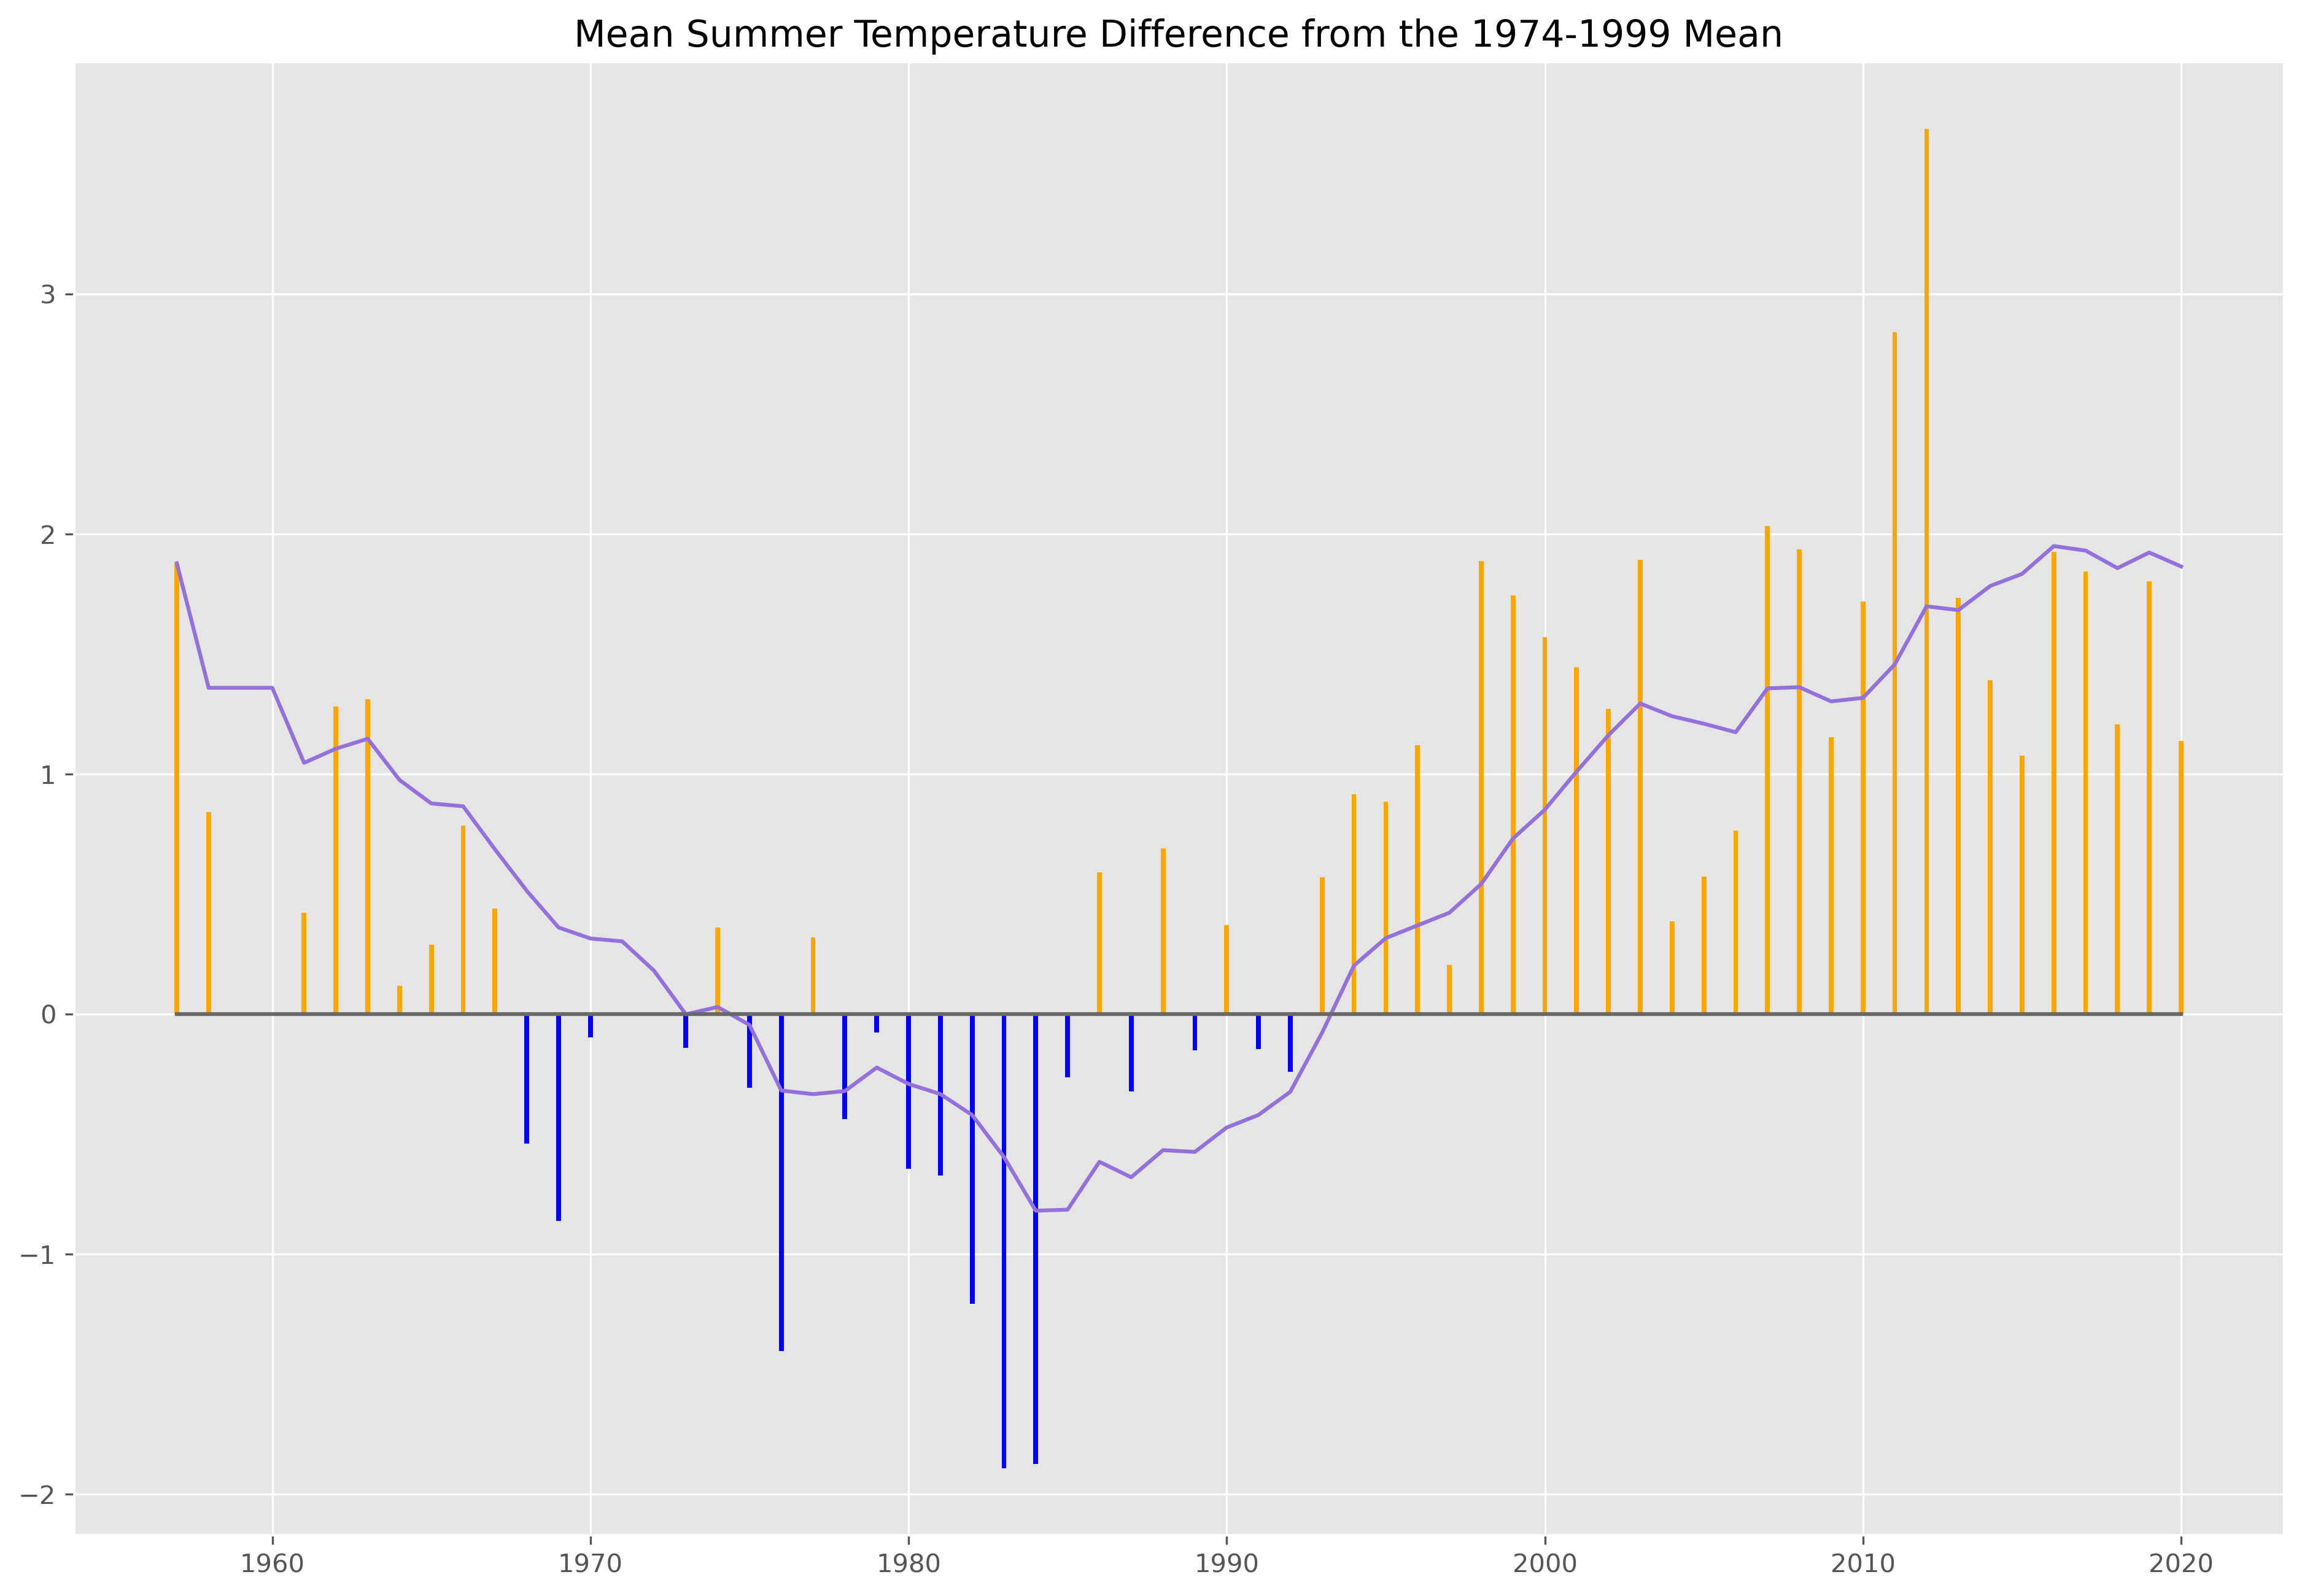

In [8]:
fig = plt.figure(dpi=300)
plt.style.use('ggplot')
ax = fig.add_axes([0,0,2,2]) #dimensions
l1 = ax.plot(df_smth.YEAR, df_smth.T_RA, color = 'mediumpurple') #rolling average temperature
l2 = ax.bar(df_smth.YEAR, df_smth.TAVG_NOAA_P, color ='orange', width = 0.15) #positive temperature
l3 = ax.bar(df_smth.YEAR, df_smth.TAVG_NOAA_N ,color ='blue', width = 0.15) #negative temperature
l4 = ax.plot([1957,2020], [0,0], color = 'dimgray') #baseline
ax.set_title("Mean Summer Temperature Difference from the 1974-1999 Mean")
plt.show()


### Conclusion

From the chart it is clear that there is a downfall in average summer temperatures through the years and then a bounce back. More specicically:
* We have a bottom in the **mid '80s** with a deviation below **$1,5^{\circ}C$**.
* At the begging of **'10s** we observe the highest summer temperatures. It is worth mentioning that in **2012** we have a deviation of **$3,5^{\circ}C$** above the mean summer temperature.

## Part 3: Evolution of Daily Temperatures
---
In this part we will calculate the average temperature for each year for the full period from 1955 to 2020. We will smouth each line by using a *30 days rolling average*. The lines will be coloured from light orange to dark orang progressing through the years in ascending order to be more discrete.
Also, the average daily temperature for the baseline period of **1974-1999** will be projected in the plot, in black colour, smouthed also using a *30 days rolling average*.

### Data Preparation
#### Baseline
* Group by date the 1974-1999 dataset 
* Calculate the 30 days rolling average temperature 

In [9]:
df_d = df_74_99.groupby(df_74_99.DATE.dt.dayofyear).mean() #groupby date 74-99
df_d.reset_index(level = 0, inplace = True)
df_d['TAVG_RA'] = df_d['TAVG_NOAA'].rolling(window = 30, min_periods=1).mean() # 30 days rolling average temperature
df_d

,DATE,PRCP_NOAA,TAVG_NOAA,TAVG_HDS,PRCP_HDS,TAVG_RA
0,1,1.923077,10.365385,NaN,NaN,10.365385
1,2,0.646154,10.707692,NaN,NaN,10.536538
2,3,1.415385,10.207692,NaN,NaN,10.426923
3,4,0.176923,9.634615,NaN,NaN,10.228846
4,5,0.042308,9.919231,NaN,NaN,10.166923
...,...,...,...,...,...,...
361,362,1.061538,10.261538,NaN,NaN,11.560385
362,363,0.907692,10.653846,NaN,NaN,11.481923
363,364,0.607692,11.011538,NaN,NaN,11.433590
364,365,1.938462,11.146154,NaN,NaN,11.385256


#### Day Temperature Dataframe
* Set an *Year* and *Date* column on initial dataset 
* Calculate the 30 days rolling average temperature 
* Drop unnecessary columns
* Group by *Year* and *Date* 
* Pivot the dataframe on temperature with *Date* as index

In [10]:
df_m['Year'] = df_m.DATE.dt.year #set year column 
df_m['Date'] = df_m.DATE.dt.dayofyear #set date column
df_m['T_RA'] = df_m['TAVG_NOAA'].rolling(window = 30, min_periods=1).mean() # 30 days rolling average temperature
df_m1 = df_m.drop(['DATE','PRCP_NOAA','TAVG_NOAA','TAVG_HDS','PRCP_HDS'],axis = 1) #drop columns
df_m1 = df_m1.groupby(['Year','Date']).mean() # groupby year and date 
df_pv = df_m1.pivot_table(index = 'Date', columns = 'Year' , values = "T_RA") #pivot table on temperature
df_pv

Year,1957,1958,1959,1961,1962,1963,1964,1965,1966,1967,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Date,,,,,,,,,,,,,,,,,,,,,
1,NaN,11.503333,13.034483,12.000000,12.366667,11.560000,13.426667,12.763333,13.756667,12.746667,...,13.093333,12.683333,11.316667,10.473333,12.626667,10.896667,8.996667,11.960000,10.713333,12.340000
2,NaN,11.770000,13.153571,12.100000,12.283333,11.630000,13.430000,12.566667,13.726667,12.493333,...,12.806667,12.560000,11.186667,10.516667,12.116667,10.670000,8.806667,11.806667,10.606667,12.106667
3,NaN,12.020000,13.300000,12.600000,12.320000,11.703333,13.326667,12.453333,13.660000,12.376667,...,12.530000,12.426667,11.216667,10.620000,11.746667,10.600000,8.726667,11.693333,10.446667,11.983333
4,NaN,12.243333,13.453846,12.900000,12.220000,11.920000,13.110000,12.456667,13.630000,12.353333,...,12.410000,12.266667,11.190000,10.676667,11.580000,10.650000,8.730000,11.650000,10.210000,11.960000
5,NaN,12.346667,13.552000,13.380000,12.033333,12.110000,12.800000,12.503333,13.453333,12.236667,...,12.340000,12.020000,11.143333,10.713333,11.223333,10.820000,8.830000,11.710000,10.020000,11.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,10.636667,12.983333,NaN,12.766667,11.543333,13.956667,13.536667,13.773333,13.260000,12.900000,...,12.966667,12.320000,10.853333,13.990000,11.803333,9.983333,12.676667,10.710000,13.613333,14.086667
363,10.626667,13.086667,NaN,12.770000,11.413333,13.733333,13.476667,13.810000,13.113333,12.927273,...,12.793333,12.180000,10.910000,13.900000,11.703333,9.723333,12.693333,10.733333,13.160000,14.153333
364,10.776667,13.130000,NaN,12.676667,11.386667,13.583333,13.276667,13.873333,12.976667,12.913043,...,12.763333,11.943333,10.880000,13.483333,11.616667,9.466667,12.493333,10.796667,12.700000,14.153333


### Plot

<Figure size 1800x1200 with 0 Axes>

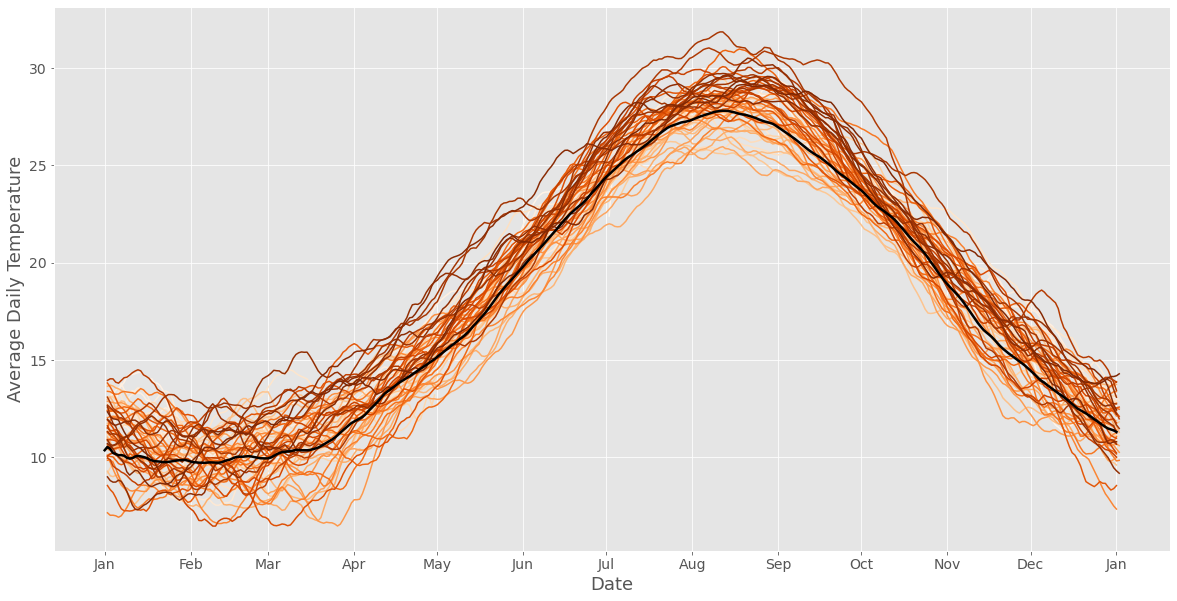

In [11]:
fig = plt.figure(dpi=300)
plt.style.use('ggplot')
df_pv.plot(legend = False , cmap = 'Oranges', figsize=(20,10)) # day temperatures 
df_d.TAVG_RA.plot(color = 'k', linewidth = 2.5) # baseline temperature
plt.xlabel('Date',fontsize = 18) 
plt.ylabel('Average Daily Temperature',fontsize = 18)      
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) #locate months
plt.gca().xaxis.set_major_formatter(DateFormatter('%b')) #name months
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

### Conclusion
In the above plot we firstly see that the most darkest oranges lines are above the black line and the lightest orange lines are below it. More specific, we see the above pattern in summer and spring months. On the other hand, in winter months the lines are more mixed. To sum up:
* The last years, in **summer months**, we have an increase in temperatures.
* In **winter months**, the temperature is more mixed through the years.

## Part 4: Extreme Temperature Events
---
Exteme events, that's what we will measure in this part. Extreme events are defined as those beyond 5% or 10% from the expected value. We will deal with extreme heat events going **10%** above the baseline.
Again, we will use the **1974-1999** period as our baseline and compare it with the yearly extreme events. At the end, we will count the number of extreme events of the **1974-1999** period and plot it in the diagram.
### Data Preparation
#### Baseline
* Use the 1974-1999 dataset, group by date
* Calculate the extreme heat events baseline temperature
* Drop unnecessary columns

In [12]:
df_d['TAVG_NOAA_BL'] = 1.1*df_d['TAVG_NOAA'] #q3 df_d από 1974 - 1999 group by date / calculate extreme heat baseline temperature 
df_db1 = df_d.drop(['PRCP_NOAA','TAVG_NOAA','TAVG_HDS','PRCP_HDS','TAVG_RA'],axis = 1) #drop columns
df_db1

,DATE,TAVG_NOAA_BL
0,1,11.401923
1,2,11.778462
2,3,11.228462
3,4,10.598077
4,5,10.911154
...,...,...
361,362,11.287692
362,363,11.719231
363,364,12.112692
364,365,12.260769


#### Day extreme event temperature dataframe (True/False values)
* On initial dataset, drop unnecessary columns
* Group by *Year* and *Date*
* Pivot the dataframe on temperature with *Date* as index
* Join with the baseline dataframe above
* Drop again unnecessary columns
* Compare each temperature with baseline temperature and set True or False

In [13]:
df_m2 = df_m.drop(['DATE','PRCP_NOAA','T_RA','TAVG_HDS','PRCP_HDS'],axis = 1) #drop columns
df_m2 = df_m2.groupby(['Year','Date']).mean() # groupby year and date 
df_pv = df_m2.pivot_table(index = 'Date', columns = 'Year' , values = "TAVG_NOAA") #pivot table on temperature
df_pv.reset_index(level = 0, inplace = True)
df_pv1 = df_pv.join(df_db1) #join the two dataframes
df_pv1 = df_pv1.drop(['Date','DATE'],axis=1) #drop columns
df_tf = df_pv1.iloc[:, :-1].apply(lambda x: np.where(x > df_pv1.TAVG_NOAA_BL, True, False), axis=0)  # Compare the columns and set True False 
df_tf

,1957,1958,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,False,True,True,True,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,True,True,True,True,False,True,True,False,True,...,False,False,False,False,False,False,False,True,False,False
2,False,True,True,True,True,False,True,True,True,True,...,False,False,True,False,False,True,False,True,False,False
3,False,False,True,True,True,False,True,True,True,True,...,False,True,True,True,True,True,True,False,False,False
4,False,False,True,False,True,False,True,False,True,False,...,False,True,True,True,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,False,True,True,True,True,True,True,False,True,True,...,False,True,True,True,True,False,True,False,False,True
362,True,True,True,True,False,True,True,False,True,True,...,False,True,True,True,True,False,True,False,False,True
363,True,False,True,True,False,False,True,False,True,True,...,False,False,True,False,False,False,False,False,False,True
364,True,False,True,True,False,True,True,False,True,False,...,False,False,False,False,False,False,False,False,False,True


#### Year extreme heat event temperature dataframe
* Sum the number of extreme heat event temperatures
* Count the observations per year
* Calculate the percentage of extreme heat events over the number of observations for each year.

In [14]:
df_ee = df_tf.sum()  # number of extreme events per year
df_ee = pd.DataFrame(df_ee, columns = ['Extreme_Events']).reset_index().rename(columns={"index":"Year"}) #to dataframe
df_o = df_pv1.drop(['TAVG_NOAA_BL'], axis = 1).count() # number of observations per year
df_o = pd.DataFrame(df_o, columns = ['Observations']).reset_index().rename(columns={ "index":"Year" }) #to dataframe
df_o['Percentage']=df_ee['Extreme_Events']/df_o['Observations'] #percentage calculation
df_o


,Year,Observations,Percentage
0,1957,184,0.271739
1,1958,365,0.367123
2,1961,365,0.372603
3,1962,365,0.421918
4,1963,364,0.390110
...,...,...,...
56,2016,366,0.431694
57,2017,365,0.463014
58,2018,365,0.460274
59,2019,365,0.435616


#### 1974-1999 extreme heat events temperature percentage (baseline)
* From extreme event dataframe extract the 1974-1999 period and sum up the values
* From observations dataframe extract the 1974-1999 period and sum up the values
* Calculate the extreme heat event temperature percentage

In [15]:
df_eebl = df_ee.loc[(df_ee['Year']>= 1974) & (df_ee['Year']<= 1999)] #1974-1999 extreme events values 
ee_bl = df_eebl.Extreme_Events.sum() #1974-1999 extreme events values sum
df_obl = df_o.loc[(df_o['Year'] >= 1974) & (df_o['Year']<= 1999)] #1974-1999 observation values 
o_bl = df_obl.Observations.sum() #1974-1999 observation values sum
baseline = ee_bl/o_bl #extreme heat event temperature percentage
print("The 1974-1999 extreme heat event temperature percentage is: ","{:.3f}".format(baseline))
df_o['Percentage_P'] = df_o.Percentage.loc[(df_o['Percentage'] - baseline >= 0)] #values above percentage baseline
df_o['Percentage_N'] = df_o.Percentage.loc[(df_o['Percentage'] - baseline < 0)] #values below percentage baseline



The 1974-1999 extreme heat event temperature percentage is:  0.248


### Plot

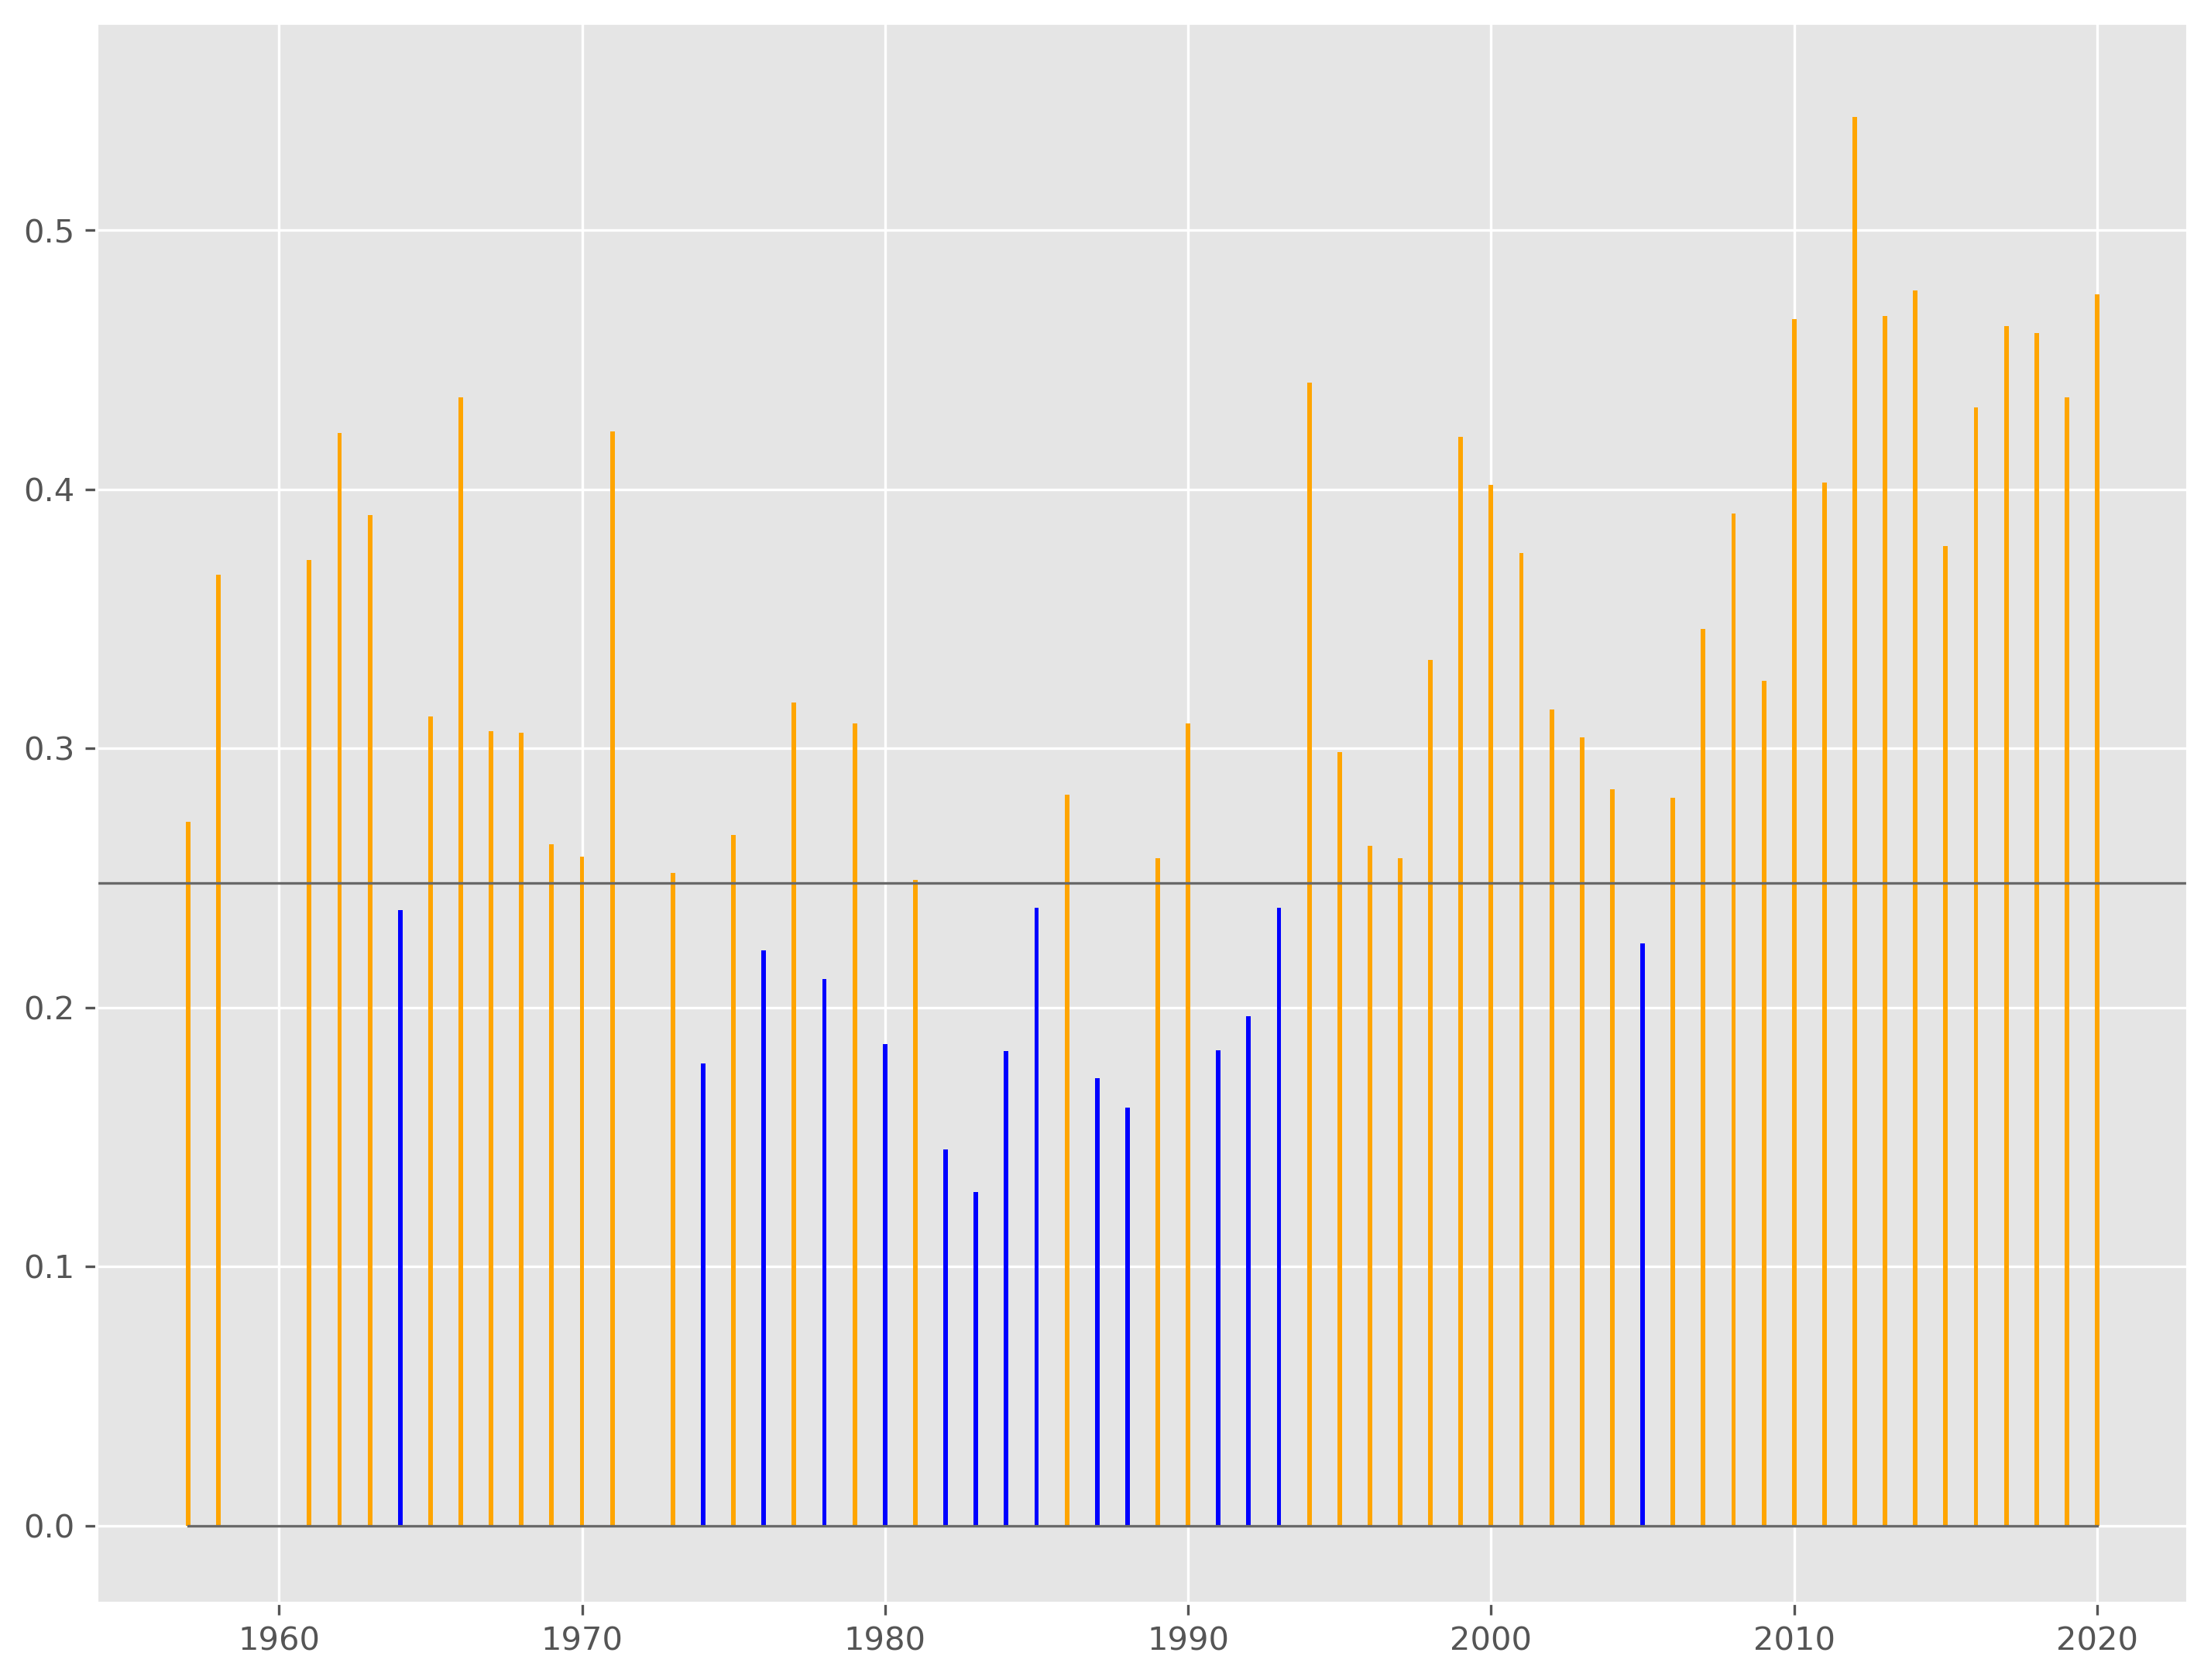

In [16]:
fig = plt.figure(dpi=300)
plt.style.use('ggplot')
ax = fig.add_axes([0,0,1.5,1.7]) #dimensions
l1 = ax.bar(df_o.Year, df_o.Percentage_P, color ='orange', width = 0.15) #values above percentage baseline
l2 = ax.bar(df_o.Year, df_o.Percentage_N, color ='blue', width = 0.15) #values below percentage baseline
l3 = ax.plot( [1957,2020] ,[0,0] ,color = 'dimgray',linewidth = 0.8) #baseline
l4 = ax.hlines(y=baseline, xmin = 1954, xmax = 2025, color='dimgray',linewidth = 0.8) #baseline percentage
ax.set_ylim(-0.03, 0.58)
ax.set_xlim(1954,2023)
plt.show()

### Conclusion
From **mid '70s** to the **beginning of '90s** the extreme heat events was below the baseline in the most years, something that accords from the two previous plots. Combining that in this period the mean summer temperatures was below the baseline and the winter temperatures are mostly in the same range all of the years, is something that we expect it to see. 
<br>On the other hand, **after 2010** we have a lot more extreme events. Something, also we wait to see, as we combine the two above graphs.

## Part 5: Precipitation
---
In the last part we will deal with rainfall as another form of extreme events. The weather may or may not be drying up. We are, however, interested in whether precipication becomes more intense over time. <br>We will count the overall rainfall over the year and the number of rainy days in each year. Then, by dividing the rainfall by the number of rainy days we will get an indication of whether we are getting rain in more concentrated bursts. Also, on the plot we will overlay the *10 years rolling average* of precipitation.
### Data Preparation
#### Year precipitation dataframe
* Group by year our initial dataset and drop unnecessary columns
* Replace 0.00 values with NaN from initial data set and count rain days
* Calculate the percentage of rainy days per year
* Calculate the 10 year rolling average precipitation

In [17]:
df_p_y = df_m.groupby(df_m.DATE.dt.year).sum() #group by year
df_p_y = df_p_y.drop(['TAVG_NOAA','TAVG_HDS','PRCP_HDS','T_RA','Year','Date'],axis = 1) #drop columns
df_p_y.reset_index(level = 0, inplace = True)
df_p = df_m.PRCP_NOAA.replace(0.0, np.nan)  #replace 0 values
df_p = df_p.groupby(df_m.DATE.dt.year).count() #count rain days per year 
df_p = pd.DataFrame(df_p)
df_p.reset_index(level = 0, inplace = True)
df_p['PRCP_YEAR'] = df_p_y['PRCP_NOAA'] / df_p['PRCP_NOAA']  #percentage of rainy days per year
df_p['PRCP_RA'] = df_p['PRCP_YEAR'].rolling(window = 10, min_periods=1).mean() # 10 year rolling average precipitation
df_p

,DATE,PRCP_NOAA,PRCP_YEAR,PRCP_RA
0,1955,68,8.044118,8.044118
1,1956,52,5.409615,6.726867
2,1957,73,4.153425,5.869053
3,1958,68,5.147059,5.688554
4,1959,62,3.451613,5.241166
...,...,...,...,...
61,2016,42,6.228571,6.545994
62,2017,48,6.339583,6.623414
63,2018,55,6.912727,6.769177
64,2019,58,9.827586,7.214330


### Plot

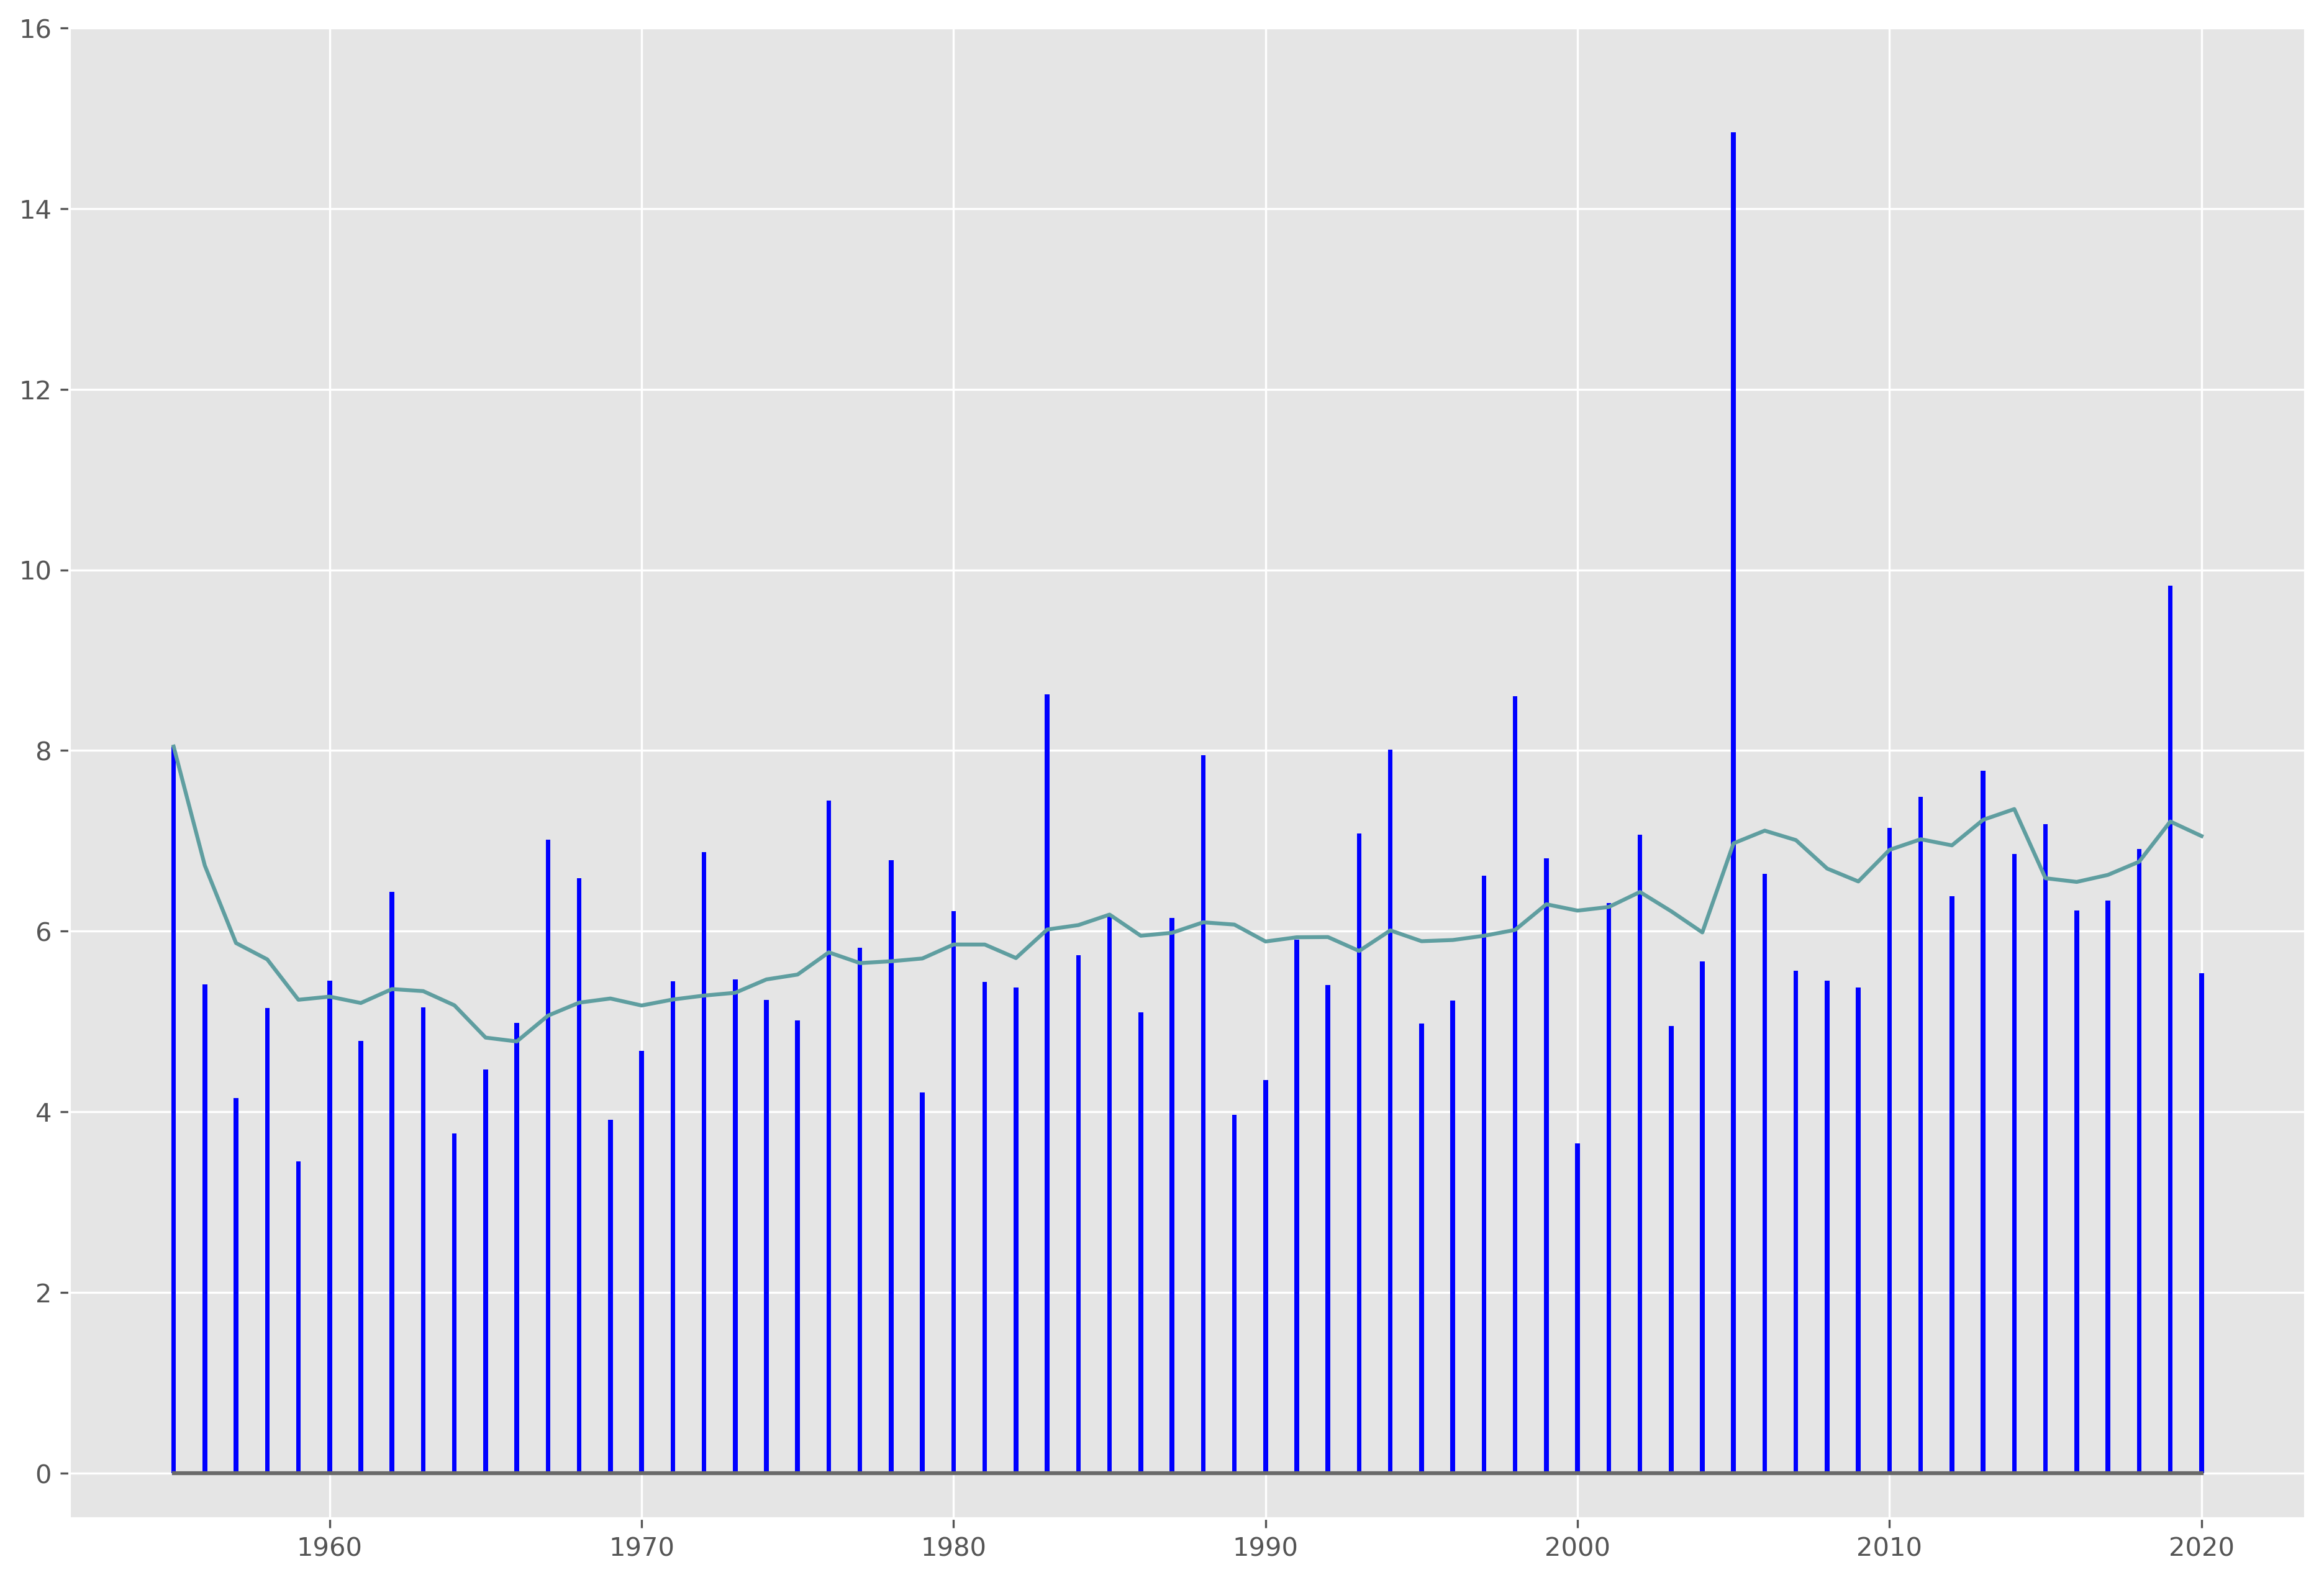

In [18]:
fig = plt.figure(dpi=300)
plt.style.use('ggplot')
ax = fig.add_axes([0,0,2,2]) #dimensions 
l1 = ax.plot(df_p.DATE, df_p.PRCP_RA , color = 'cadetblue' ) #rolling average precipitation
l2 = ax.bar(df_p.DATE, df_p.PRCP_YEAR ,color ='blue' , width = 0.15) #rain days per year
l3 = ax.plot([1955,2020] , [0,0] ,color = 'dimgray') #baseline
ax.set_ylim(-0.5 ,16)
plt.show()

### Conclusion
At the first glance our diagram is smooth. The ratio of rainfall over rainy days is in the same range through the years. Nevertheless there are a couple of years with extreme rain burst. In **2005** more specific, the rainfall ratio was as double as usual.<br> In further attention, we see local tops every **4-5 years**. 